In [0]:
#installing library for model compression
pip install kerassurgeon

In [0]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as k
from keras.datasets import mnist

batch_size = 256
num_class = 10
epochs = 2

img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)






x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Model creation
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)      

In [0]:
#model training and weight saving
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs, 
            verbose=1, 
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_name = 'convnet'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 172s 3ms/step - loss: 0.3788 - acc: 0.8822 - val_loss: 0.1008 - val_acc: 0.9684
Epoch 2/2
60000/60000 [==============================] - 173s 3ms/step - loss: 0.1097 - acc: 0.9672 - val_loss: 0.0568 - val_acc: 0.9811
Test loss: 0.05676591616256628
Test accuracy: 0.9811

Model saved as convnet.h5
Weights also saved separately as convnet_weights.h5



In [0]:
#upload keras surgeon library

from kerassurgeon import identify
from keras.models import load_model
from kerassurgeon.operations import delete_layer, insert_layer, delete_channels

#%load_ext autoreload
#%autoreload 2

In [0]:
#Load the saved model

model = load_model('convnet.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [0]:
#printing model layers detail
print(model.layers)
for i in range(len(model.layers)):
 if len(model.layers[i].get_weights())!=0:
        print("Layer Number:",i,"Layer Shape: ",model.layers[i].get_weights()[0].shape)

[<keras.layers.convolutional.Conv2D object at 0x7f30d9fd7278>, <keras.layers.convolutional.Conv2D object at 0x7f30d9fd7438>, <keras.layers.pooling.MaxPooling2D object at 0x7f30d976fd30>, <keras.layers.core.Dropout object at 0x7f30d9fd75f8>, <keras.layers.core.Flatten object at 0x7f30d9786e48>, <keras.layers.core.Dense object at 0x7f30d9786be0>, <keras.layers.core.Dropout object at 0x7f30d975c6d8>, <keras.layers.core.Dense object at 0x7f30d975c358>]
Layer Number: 0 Layer Shape:  (3, 3, 1, 32)
Layer Number: 1 Layer Shape:  (3, 3, 32, 64)
Layer Number: 5 Layer Shape:  (9216, 128)
Layer Number: 7 Layer Shape:  (128, 10)


In [0]:
#Structural compression

#Visualize model weights 

import matplotlib.pyplot as plt
import numpy as np

# load the model
model = load_model('convnet.h5')

#print(model.summary())
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0)
loss_before_compress = score[0]
accuracy_before_compress = score[1]
print('Test loss before compression:', loss_before_compress)
print('Test accuracy before compression:', accuracy_before_compress)


# load the weight of a Convolution layer 1
# 0 for first layer, 1 for second layer

w1 = model.layers[0].get_weights()
#w2 = model.layers[1].get_weights()[0]
#w1 = model.layers[5].get_weights()[0]
#conv_layer_weights = [w1,w2]
#conv_layer_weights = [w1]


print(w1[0].shape)
print('non zero weights',np.count_nonzero(w1[0]))


th = np.mean(w1[0])
print('Threshold',th)


#print(conv_layer_weights)
#if a weight is less than thresold then convert to zero

w1[0][w1[0]<th]=0

#print(w1)
print(w1[0].shape)

model.layers[0].set_weights(w1)

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss Afeter compression:', score[0])
print('Test accuracy after compression:', score[1])
print('non zero weights', np.count_nonzero(w1[0]))


print('Test loss before compression:', loss_before_compress)
print('Test accuracy before compression:', accuracy_before_compress)

Test loss before compression: 0.05676591616256628
Test accuracy before compression: 0.9811
(3, 3, 1, 32)
non zero weights 288
Threshold 0.0319021
(3, 3, 1, 32)
Test loss Afeter compression: 0.31668553807735444
Test accuracy after compression: 0.9111
non zero weights 151
Test loss before compression: 0.05676591616256628
Test accuracy before compression: 0.9811


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

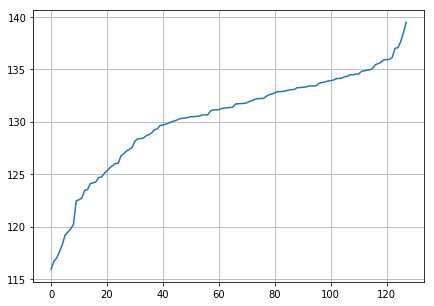

In [0]:
#Weight prunning
#Node prunning of fully connected layer



import matplotlib.pyplot as plt
import numpy as np
model = load_model('convnet.h5')
print(model.summary())

# get fully connected layer weight

w1 = model.layers[5].get_weights()[0]
#w2 = model.layers[1].get_weights()[0]

#conv_layer_weights = [w1,w2]
layer_weights = [w1]

#calculating L1 norm for a layer of the model  

for i in range(len(layer_weights)):
  weight = layer_weights[i]
  #print(weight)
  weight_dict={}
  
  num_filter = len(weight[0,:])
  #num_filter = len(weight[0,0,0,:])
  for j in range(num_filter):
    w_s=np.sum(abs(weight[:,j]))
    #w_s=np.sum(abs(weight[:,:,:,j]))
    #filt='filt_{}'.format(j)
    weight_dict[j] = w_s
  weight_dict_sort=sorted(weight_dict.items(),key=lambda kv:kv[1])
  print('L1 normconv layer {}\n'.format(i+1),weight_dict_sort)
 
#get L1 norm value and plot it

  weights_value=[]
  for y in weight_dict_sort:
    weights_value.append(y[1])
  
  xc= range(num_filter)
  plt.figure(i+1, figsize=(7,5))
  plt.plot(xc,weights_value)
  plt.grid(True)
  plt.style.use(['classic'])
  
 

In [0]:
 #Delete Nodes from the Model.
  
dense_1 = model.layers[5]

#enter which node you wanted to delete

model = delete_channels(model, dense_1, [3,38,83])
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss Afeter compression:', score[0])
print('Test accuracy after compression:', score[1])


print('Test loss before compression:', loss_before_compress)
print('Test accuracy before compression:', accuracy_before_compress)

Deleting 3/128 channels from layer: dense_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (No

Test loss: 0.048280825416138394
Test accuracy: 0.9839


In [0]:
#Weight prunning
#filter prunning of convolution layer

model = load_model('convnet.h5')

#w1 = model.layers[0].get_weights()[0]

# 2nd layer in the model is convolution layer
# getting weights of convolution layer
w2 = model.layers[1].get_weights()[0]

#conv_layer_weights = [w1,w2]
conv_layer_weights = [w2]


for i in range(len(conv_layer_weights)):
  weight = conv_layer_weights[i]
  #print(weight)
  weight_dict={}
  
  #num_filter = len(weight[0,:])
  num_filter = len(weight[0,0,0,:])
  for j in range(num_filter):
    #w_s=np.sum(abs(weight[:,j]))
    #taking L1 norm of the weight
    w_s=np.sum(abs(weight[:,:,:,j]))
    weight_dict[j] = w_s
  weight_dict_sort=sorted(weight_dict.items(),key=lambda kv:kv[1])
  print('L1 normconv layer {}\n'.format(i+1),weight_dict_sort)


#select number of filter you want to prune

n = 20
x=[]

for i in range(n):
  x.append(weight_dict_sort[i][0])
print(x)


dense_1 = model.layers[1]
model = delete_channels(model, dense_1, x)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss Afeter compression:', score[0])
print('Test accuracy after compression:', score[1])


print('Test loss before compression:', loss_before_compress)
print('Test accuracy before compression:', accuracy_before_compress)

L1 normconv layer 1
 [(19, 11.670492), (54, 11.691042), (7, 11.75297), (10, 12.128744), (47, 12.234194), (60, 12.317528), (32, 12.37105), (56, 12.390006), (0, 12.3949585), (50, 12.443481), (30, 12.450472), (22, 12.79537), (39, 12.851103), (52, 12.957601), (5, 12.98576), (42, 13.005476), (43, 13.011995), (4, 13.01382), (53, 13.024656), (46, 13.071514), (24, 13.148503), (28, 13.207314), (8, 13.213285), (55, 13.2518425), (26, 13.347278), (31, 13.40442), (25, 13.407949), (1, 13.473665), (29, 13.572489), (35, 13.59551), (16, 13.641783), (2, 13.880938), (45, 13.886072), (38, 13.995516), (51, 14.030996), (63, 14.044562), (13, 14.079163), (20, 14.186078), (23, 14.227537), (27, 14.262571), (17, 14.372299), (57, 14.52813), (9, 14.674097), (44, 14.714343), (11, 14.755711), (59, 14.794771), (48, 14.830628), (21, 14.924862), (49, 14.964878), (33, 15.026666), (37, 15.128296), (40, 15.153286), (12, 15.238215), (61, 15.360361), (58, 15.393203), (41, 15.525232), (18, 15.909038), (14, 15.987936), (34, 1

In [0]:
#Delete weights from both fully conected layr and convolution layer

import matplotlib.pyplot as plt
import numpy as np
model = load_model('convnet.h5')
print(model.summary())

#convolution Layer 

w2 = model.layers[1].get_weights()[0]

conv_layer_weights = [w2]


for i in range(len(conv_layer_weights)):
  weight = conv_layer_weights[i]
  #print(weight)
  weight_dict={}
  
  #num_filter = len(weight[0,:])
  num_filter = len(weight[0,0,0,:])
  for j in range(num_filter):
    #w_s=np.sum(abs(weight[:,j]))
    #taking L1 norm of the weight
    w_s=np.sum(abs(weight[:,:,:,j]))
    weight_dict[j] = w_s
  weight_dict_sort=sorted(weight_dict.items(),key=lambda kv:kv[1])
  print('L1 normconv layer {}\n'.format(i+1),weight_dict_sort)


#select number of filter you want to prune

n = 10
y=[]

for i in range(n):
  y.append(weight_dict_sort[i][0])
print(y)


# get fully connected layer weight

w1 = model.layers[5].get_weights()[0]
#w2 = model.layers[1].get_weights()[0]

#conv_layer_weights = [w1,w2]
layer_weights = [w1]

#calculating L1 norm for a layer of the model  

for i in range(len(layer_weights)):
  weight = layer_weights[i]
  #print(weight)
  weight_dict={}
  
  num_filter = len(weight[0,:])
  #num_filter = len(weight[0,0,0,:])
  for j in range(num_filter):
    w_s=np.sum(abs(weight[:,j]))
    #w_s=np.sum(abs(weight[:,:,:,j]))
    #filt='filt_{}'.format(j)
    weight_dict[j] = w_s
  weight_dict_sort=sorted(weight_dict.items(),key=lambda kv:kv[1])
  print('L1 normconv layer {}\n'.format(i+1),weight_dict_sort)
  
n = 5
x=[]

for i in range(n):
  x.append(weight_dict_sort[i][0])
print(x)


conv_1 = model.layers[1]
model = delete_channels(model, conv_1, y)

print("After Deleting convolution layer")
model.summary()


dense_1 = model.layers[6]
model = delete_channels(model, dense_1, x)


model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss Afeter compression:', score[0])
print('Test accuracy after compression:', score[1])


print('Test loss before compression:', loss_before_compress)
print('Test accuracy before compression:', accuracy_before_compress)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Test loss: 0.04710421532569453
Test accuracy: 0.9839
(3, 3, 1, 32)
288
0.032692477
(3, 3, 1, 32)
Test loss: 0.13691150419712067
Test accuracy: 0.9714
154


In [0]:
#Retrain model after deleting the weights and filter
#Delete weights from both fully conected layr and convolution layer

import matplotlib.pyplot as plt
import numpy as np
model = load_model('convnet.h5')
print(model.summary())

#convolution Layer 

w2 = model.layers[1].get_weights()[0]

conv_layer_weights = [w2]


for i in range(len(conv_layer_weights)):
  weight = conv_layer_weights[i]
  #print(weight)
  weight_dict={}
  
  #num_filter = len(weight[0,:])
  num_filter = len(weight[0,0,0,:])
  for j in range(num_filter):
    #w_s=np.sum(abs(weight[:,j]))
    #taking L1 norm of the weight
    w_s=np.sum(abs(weight[:,:,:,j]))
    weight_dict[j] = w_s
  weight_dict_sort=sorted(weight_dict.items(),key=lambda kv:kv[1])
  print('L1 normconv layer {}\n'.format(i+1),weight_dict_sort)


#select number of filter you want to prune

n = 10
y=[]

for i in range(n):
  y.append(weight_dict_sort[i][0])
print(y)


# get fully connected layer weight

w1 = model.layers[5].get_weights()[0]
#w2 = model.layers[1].get_weights()[0]

#conv_layer_weights = [w1,w2]
layer_weights = [w1]

#calculating L1 norm for a layer of the model  

for i in range(len(layer_weights)):
  weight = layer_weights[i]
  #print(weight)
  weight_dict={}
  
  num_filter = len(weight[0,:])
  #num_filter = len(weight[0,0,0,:])
  for j in range(num_filter):
    w_s=np.sum(abs(weight[:,j]))
    #w_s=np.sum(abs(weight[:,:,:,j]))
    #filt='filt_{}'.format(j)
    weight_dict[j] = w_s
  weight_dict_sort=sorted(weight_dict.items(),key=lambda kv:kv[1])
  print('L1 normconv layer {}\n'.format(i+1),weight_dict_sort)
  
n = 5
x=[]

for i in range(n):
  x.append(weight_dict_sort[i][0])
print(x)


conv_1 = model.layers[1]
model = delete_channels(model, conv_1, y)


dense_1 = model.layers[6]
model = delete_channels(model, dense_1, x)


model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss Afeter compression:', score[0])
print('Test accuracy after compression:', score[1])


model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs, 
            verbose=1, 
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)


print('Test loss Afeter compression and retraining:', score[0])
print('Test accuracy after compression and retraining:', score[1])


print('Test loss before compression:', loss_before_compress)
print('Test accuracy before compression:', accuracy_before_compress)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________